# Анализ АВ-теста

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-09-28 по 2023-10-04 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные А/B-теста. 

**1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5), а также t-тест и тест Манна-Уитни поверх бакетного преобразования).** 

Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так?

Контрольная группа - 1. Тестовая группа - 2

H0: CTR_1 = CTR_2 

H1: CTR_1 != CTR_2

In [1]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
import statsmodels.api as sm

%matplotlib inline

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20231020',
              'user':'student',
              'password':'_'
             }

In [3]:
quest = """
            SELECT exp_group, 
                user_id,
                SUM(action = 'like') as likes,
                SUM(action = 'view') as views,
                likes/views as ctr
            FROM 
                simulator_20231020.feed_actions
            WHERE 
                toDate(time) BETWEEN '2023-09-28' AND '2023-10-04'
                AND exp_group in (1, 2)
            GROUP BY 
                exp_group, 
                user_id
            """

df = ph.read_clickhouse(quest, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


<AxesSubplot:xlabel='ctr', ylabel='Count'>

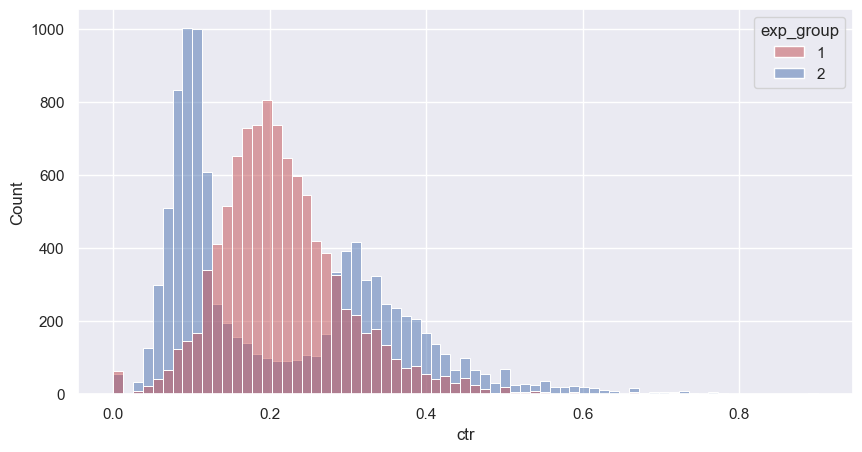

In [4]:
# Посмотрим на распределение в группах 1 и 2

sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data = df, 
             x='ctr', 
             hue='exp_group', 
             palette=['r', 'b'], 
             alpha=0.5, 
             kde=False)

Мы видим, что распределение нашей тестовой группы 2 является бимодальным, с достаточно большой дисперсией. В соответствии с заданием, посмотрим как различные тесты будут улавливать различия в ctr между нашими группами

In [5]:
stats.ttest_ind(df[df.exp_group == 1]['ctr'], 
                df[df.exp_group == 2]['ctr'], 
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

In [6]:
stats.mannwhitneyu(df[df.exp_group == 1]['ctr'], 
                   df[df.exp_group == 2]['ctr'])

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Таким образом мы получили 2 провоположных результата. Вероятно, это связано с нарушением требований о нормальности распределения, которые требуются для т-теста

In [7]:
# t-тест на сглаженном ctr (α=5)

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [8]:
# Сравниваем распределение обычного CTR и сглаженного для 1 группы

group1 = df[df.exp_group == 1].copy()
group1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

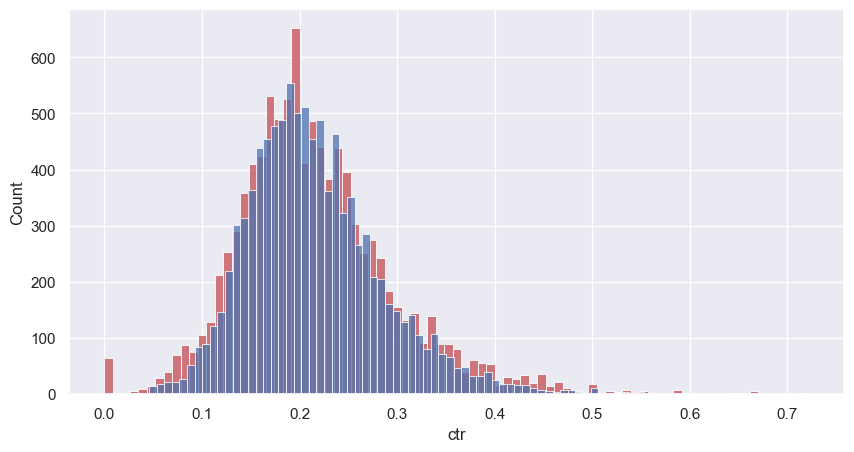

In [9]:
sns.histplot(group1.ctr, kde = False, color='r')
sns.histplot(group1.smothed_ctr, kde = False, color='b')

In [10]:
# Сравниваем распределение обычного CTR и сглаженного для 2 группы

group2 = df[df.exp_group == 2].copy()
group2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

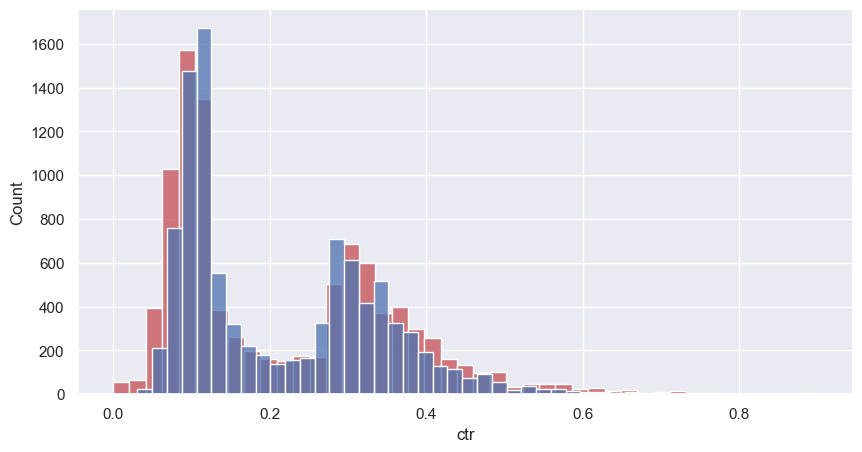

In [11]:
sns.histplot(group2.ctr, kde = False, color='r')
sns.histplot(group2.smothed_ctr, kde = False, color='b')

In [12]:
stats.ttest_ind(group1['smothed_ctr'], 
                group2['smothed_ctr'], 
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

In [13]:
stats.mannwhitneyu(group1['smothed_ctr'], 
                   group2['smothed_ctr'])

MannwhitneyuResult(statistic=55528353.0, pvalue=2.396534039374286e-50)

Снова видим противоречивые результаты. Но также мы помним, что использование метода сглаженного CTR не имеет под собой никаких теоретических гарантий, поэтому не можем положиться на его результаты.

In [14]:
(global_ctr_1, global_ctr_2)

(0.2096041628394293, 0.20025051027061783)

Мы видим, что значение глобального ctr у группы 2 уменьшилась, но t-тест это отличие таке не может заметить.

In [15]:
# Пуассоновский бутстреп

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

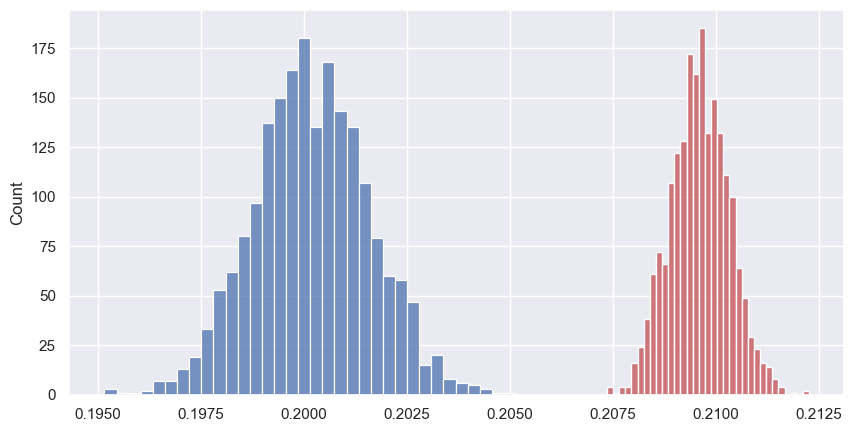

In [16]:
sns.histplot(ctr1, color='r')
sns.histplot(ctr2, color='b')

<AxesSubplot:ylabel='Count'>

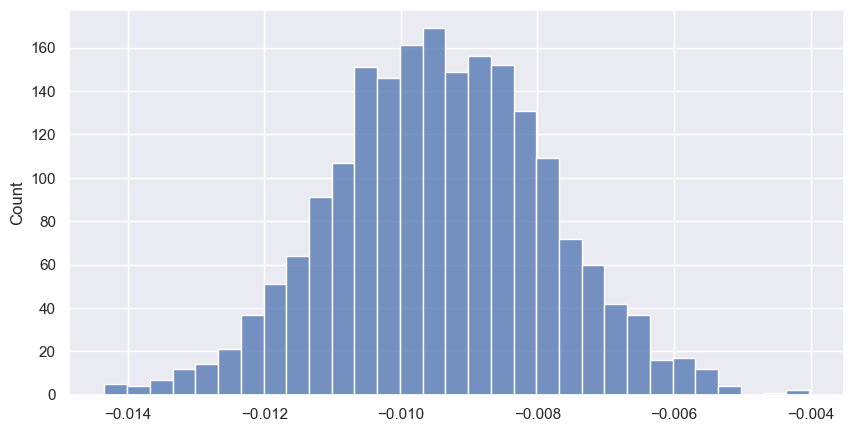

In [17]:
# Разница между глобальными CTR

sns.histplot(ctr2 - ctr1)

Таким образом, бутстреп говорит нам, что новый алгоритм (группа 2) значимо хуже, чем старый алгоритм (т.к. разница между группами не нулевая)

In [18]:
# Бакетное преобразование

quest_bucket = """
                    SELECT 
                        exp_group, 
                        bucket,
                        SUM(likes)/sum(views) as bucket_ctr
                    FROM 
                        (
                        SELECT 
                            exp_group, 
                            xxHash64(user_id) % 50 as bucket,
                            user_id,
                            SUM(action = 'like') as likes,
                            SUM(action = 'view') as views,
                            likes/views as ctr
                        FROM 
                            simulator_20231020.feed_actions 
                        WHERE 
                            toDate(time) BETWEEN '2023-09-28' AND '2023-10-04'
                            AND exp_group in (1,2)
                        GROUP BY 
                            exp_group, 
                            bucket, user_id
                        )
                    GROUP BY 
                        exp_group, 
                        bucket
                    """

df_bucket = ph.read_clickhouse(quest_bucket, connection=connection)

In [19]:
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

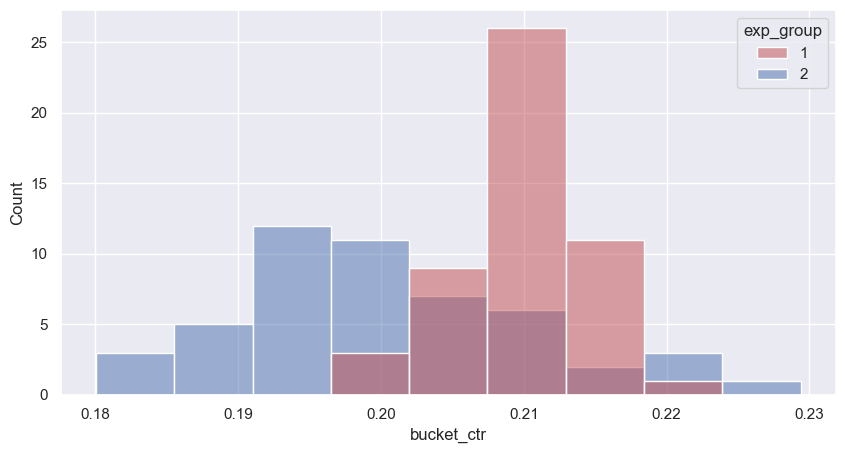

In [20]:
# Сравним распределения двух групп с бакетным преобразованием

sns.histplot(data = df_bucket, 
             x='bucket_ctr', 
             hue='exp_group', 
             palette=['r', 'b'], 
             alpha=0.5, 
             kde=False)

Бакетное распределение также явно отличается

**2. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте**

С точки зрения общегруппового ctr наш новый алгоритм стал хуже, чем был. Это подтверждает бутстреп, тест Манна-Уитни поверх бакетов и мы видим эту разницу визуально.

Но ситуация, которая у нас получилась намекает на проведением дополнительных исследований (почему образовалось бимодальное распределение). Потому что новый алгоритм как будто разделил наших пользователей: один пик уехал влево и ctr стал меньше, а второй - вправо и ctr вырос.

**3. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.**

In [21]:
df.groupby('exp_group', as_index=False).agg({'user_id':'count', 
                                             'likes':'sum', 
                                             'views':'sum', 
                                             'ctr':'mean'})

,exp_group,user_id,likes,views,ctr
0,1,10020,140339,669543,0.216774
1,2,9877,132056,659454,0.216102


Если мы посмотрим на наши основные метрики, то увидим, что во второй группе все значения снизились, в том числе и наш CTR. Такую же динамику мы отмечали и на большинстве графиков выше. Так как снизились и лайки и просмотры можем предположить, что новый алгоритм не зашел пользователям (например, он мог предлагать неинтересные новости, большие лонгриды/или наоборот слишком короткие новости). В этой связи, я бы не рекомендовала применять новый алгоритм на всех пользователей.